In [ ]:
!pip install torch torchvision

In [ ]:
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

/bin/bash: line 1: conda: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-r_4gwgo2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-r_4gwgo2
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=ce32d77a5a80584fa44aa36568d0418a6052c89e7e4e2e34ccc71005de7cd232
  Stored in directory: /tmp/pip-ephem-wheel-cache-dnpf0thh/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
!pip install torch transformers

## **Question 1 Load the Pre-trained CLIP Model in pytorch**

In [ ]:
import torch
from transformers import CLIPModel

# Load the CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")

# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters in CLIP: {total_params:,}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

Total number of parameters in CLIP: 149,620,737


In [ ]:
# This loads the image encoder of CLIP and specifies the number of parameter for this alone
image_encoder = model.vision_model
image_encoder_params = sum(p.numel() for p in image_encoder.parameters())
print(f"Parameters in CLIP's image encoder: {image_encoder_params:,}")

Parameters in CLIP's image encoder: 85,799,424


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Question 2 Load the CIFAR-10 dataset and visualize 5 examples**

In [ ]:
# import torch
# import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [ ]:
# Define the transform
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
data_dir = '/content/drive/MyDrive/CS6784/cifar-10-batches-py/'

In [ ]:
# Function to load CIFAR-10 batch
def load_cifar_batch(file_path):
    with open(file_path, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch[b'data'], batch[b'labels']

In [ ]:
# Load training data
X_train, y_train = [], []
for i in range(1, 6):
    data, labels = load_cifar_batch(f'{data_dir}data_batch_{i}')
    X_train.extend(data)
    y_train.extend(labels)

X_train = np.array(X_train).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
y_train = np.array(y_train)

# Load test data
X_test, y_test = load_cifar_batch(f'{data_dir}test_batch')
X_test = np.array(X_test).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
y_test = np.array(y_test)

In [ ]:
# Convert to PyTorch tensors
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train).permute(0, 3, 1, 2).float() / 255.0,
    torch.from_numpy(y_train)
)

test_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(X_test).permute(0, 3, 1, 2).float() / 255.0,
    torch.from_numpy(y_test)
)

Examples from train set:


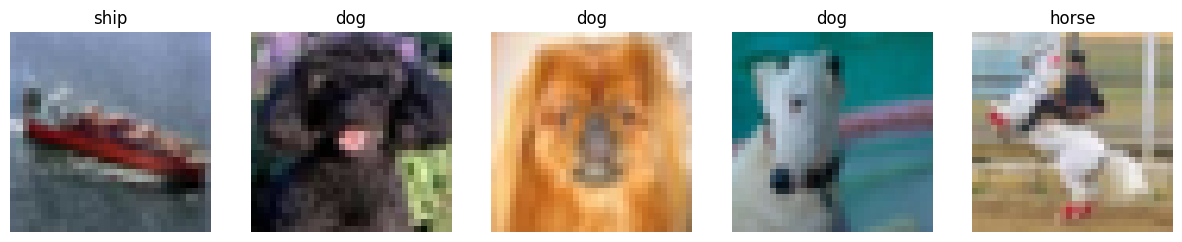

Examples from test set:


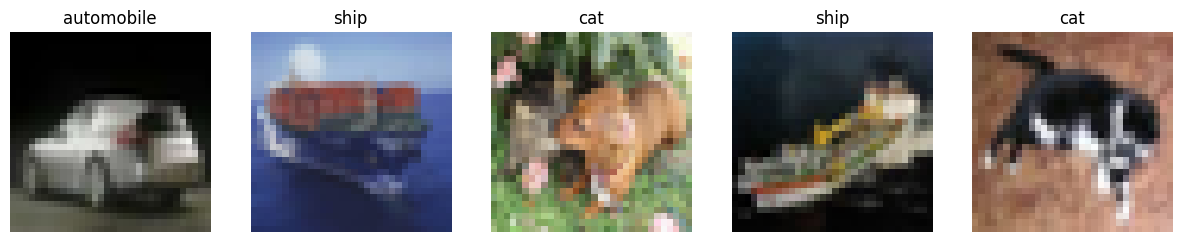

In [ ]:
# Define the classes
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to show images
def imshow(img):
    img = img.permute(1, 2, 0)  # change to (H, W, C)
    plt.imshow(img)

# Function to visualize n examples
def visualize_examples(dataset, n=5):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=n, shuffle=True)
    images, labels = next(iter(dataloader))

    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        axes[i].imshow(images[i].permute(1, 2, 0))
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()

# Visualize 5 examples from train set
print("Examples from train set:")
visualize_examples(train_dataset)

# Visualize 5 examples from test set
print("Examples from test set:")
visualize_examples(test_dataset)

## **Freeze the CLIP model and use its image embeddings for classification**

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import CLIPModel, CLIPProcessor
from tqdm import tqdm

# Load pre-trained CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

# Freeze CLIP model parameters
for param in clip_model.parameters():
    param.requires_grad = False

# Define a simple classifier
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to get CLIP embeddings
def get_clip_embeddings(images):
    inputs = processor(images=images, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = clip_model.vision_model(**inputs)
    return outputs.pooler_output

# Prepare datasets
def prepare_data(dataset, batch_size=32):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    all_embeddings = []
    all_labels = []

    for images, labels in tqdm(dataloader, desc="Preparing data"):
        embeddings = get_clip_embeddings(images)
        all_embeddings.append(embeddings)
        all_labels.append(labels)

    return torch.cat(all_embeddings), torch.cat(all_labels)

# Prepare train and test data
print("Preparing train data...")
train_embeddings, train_labels = prepare_data(train_dataset)
print("Preparing test data...")
test_embeddings, test_labels = prepare_data(test_dataset)

# Initialize classifier
input_dim = train_embeddings.shape[1]
hidden_dim = 256
num_classes = 10
classifier = Classifier(input_dim, hidden_dim, num_classes)

# Training loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
num_epochs = 10
batch_size = 64

for epoch in range(num_epochs):
    classifier.train()
    train_loader = DataLoader(list(zip(train_embeddings, train_labels)), batch_size=batch_size, shuffle=True)

    for embeddings, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = classifier(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluation
classifier.eval()
test_loader = DataLoader(list(zip(test_embeddings, test_labels)), batch_size=batch_size)
correct = 0
total = 0

with torch.no_grad():
    for embeddings, labels in tqdm(test_loader, desc="Evaluating"):
        outputs = classifier(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Calculate train accuracy
train_loader = DataLoader(list(zip(train_embeddings, train_labels)), batch_size=batch_size)
correct = 0
total = 0

with torch.no_grad():
    for embeddings, labels in tqdm(train_loader, desc="Evaluating train set"):
        outputs = classifier(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

train_accuracy = 100 * correct / total
print(f"Train Accuracy: {train_accuracy:.2f}%")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Preparing train data...


Preparing data: 100%|██████████| 1563/1563 [1:25:55<00:00,  3.30s/it]


Preparing test data...


Evaluating: 100%|██████████| 157/157 [00:00<00:00, 1206.04it/s]


Test Accuracy: 32.45%


Evaluating train set: 100%|██████████| 782/782 [00:00<00:00, 1082.12it/s]

Train Accuracy: 31.97%
